In [1]:
pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 75.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=75ed0abd5140d24fad9457d78979dc08eec7ce1869d59338482e22aeb3ab19cf
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=5c29db91da19e6ac9e0ced63bf44b380caf01e8d4ff0dd68add1cb5734c40390
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [186]:
import torch
import torch.nn as nn

import torch.optim as optim
from itertools import chain

from torch.utils.data import DataLoader, TensorDataset, Dataset

from torchsummary import summary
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import random

random.seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import torchvision.datasets
import torchvision.transforms as tr

In [214]:
class Encoder(torch.nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        self.encoder_layers = nn.Sequential(
            
            nn.Conv2d(1, 64, kernel_size = 3),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU(),
            nn.Conv2d(64, 10, 3, padding = 2),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.ReLU())

        self.fc_mu = torch.nn.Linear(latent_size, latent_size) #формирование вектора мат ожиданий
        self.fc_log_var = torch.nn.Linear(latent_size, latent_size) #формирование вектора логарифма дисперсий

        self.latent_size = latent_size

    def forward(self, x):
  
        x = self.encoder_layers(x)
 
        
        x = x.reshape(-1, self.latent_size) #делаем reshape, чтобы в полносвязку передать вектора
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var #результат кодера -- это вектор средних и вектор дисперсий
        # ============

    def sample_latent(self, x): #получаем вектор скрытого состояния Z
        mu, log_var = self.forward(x) #получае вектора средних и дисперсий

        #torch.randn_like(input) Возвращает тензор того же размера, 
        #что и input который заполнен случайными числами из стандартного нормального распределения
        N = torch.randn_like(mu).to(device)

        #дисперсия у нас возвращается в логарифме, а умножить нам надо на стандартное отклонение
        #тогда нужно /2, степень уходит и взять экспоненту, получим просто стандартное отклонение
        return torch.exp(log_var/2) * N + mu, mu, log_var

In [215]:
class Decoder(torch.nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        #ВАШ_КОД
        #нужно использовать torch.nn.UpsamplingNearest2d(scale_factor=2)
        self.decoder_layers = nn.Sequential(

            nn.Conv2d(10, 64, kernel_size = 3, padding = 1),                
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(64, 16, kernel_size = 3, padding = 1),                
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(16, 1, kernel_size = 3, padding = 1),
            nn.ReLU())


    def forward(self, x):
        # ВАШ КОД ЗДЕСЬ
        # размер вывода должен соотвествовать размеру входа на кодер
        x = self.decoder_layers(x)

        return x


In [216]:
def train_ae(data_loader, encoder, decoder, epochs, lr, device):
    print('Обучение автокодировщика..')

    encoder.train()
    decoder.train()

    recon_loss_func = torch.nn.MSELoss()

    kl_loss_func = lambda mu, log_var: -0.5 * ((1 + log_var -  torch.exp(log_var) - mu**2).sum(dim=1)).mean(dim=0)

    optimizer = optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=lr)
    loss_history = list()
    loss=0
    for epoch in range(epochs):
        for i, (batch, _) in enumerate(data_loader):

            batch = batch.to(device)

            optimizer.zero_grad()
            #прямой проход через кодер и получение вектора Z, вектора средних и вектора дисперсий
            latent_vector, mu, log_sigma = encoder.sample_latent(batch) 

            latent_vector = latent_vector.reshape(500, 10, 7, 7)
            #получение ошибки MSE
    
            recon_loss = recon_loss_func(decoder(latent_vector), batch)

            #получение ошибки KL
            kl_loss = kl_loss_func(mu, log_sigma)
            loss = kl_loss + 1000 * recon_loss

            
            loss.backward()
            optimizer.step()       

            if i % 100 == 0:
                print('Потери восстановления:', recon_loss.item())
                print('Потери расхождения распределений:', kl_loss.item())

            loss_history.append(loss.log().item())

        print(f'Эпоха {epoch + 1} / {epochs}. Потери на последнем пакете: {loss.item()}')
    # ============

    encoder.eval()
    decoder.eval()

    print('Готово!')

    plt.plot(loss_history)
    plt.show()

In [217]:
LATENT_SIZE = 10*7*7  # размерность скрытого пространства, можно варьировать.

BATCH_SIZE = 500 # можно варьировать.
EPOCHS = 15 # можно варьировать.
LEARNING_RATE = 0.001 # можно варьировать.

device = 'cuda' if torch.cuda.is_available() else 'cpu'

encoder = Encoder(LATENT_SIZE).to(device)
decoder = Decoder(LATENT_SIZE).to(device)

In [218]:
data = torchvision.datasets.MNIST('./', download = True, train = True, transform = tr.ToTensor())
train_data_loader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)

Обучение автокодировщика..
Потери восстановления: 0.11276988685131073
Потери расхождения распределений: 1.4165328741073608
Потери восстановления: 0.058450471609830856
Потери расхождения распределений: 8.826650619506836
Эпоха 1 / 15. Потери на последнем пакете: 65.76203918457031
Потери восстановления: 0.05731375515460968
Потери расхождения распределений: 9.327377319335938
Потери восстановления: 0.05048399418592453
Потери расхождения распределений: 12.067787170410156
Эпоха 2 / 15. Потери на последнем пакете: 60.80524444580078
Потери восстановления: 0.04916436970233917
Потери расхождения распределений: 11.807369232177734
Потери восстановления: 0.046324487775564194
Потери расхождения распределений: 12.939056396484375
Эпоха 3 / 15. Потери на последнем пакете: 58.506141662597656
Потери восстановления: 0.046500153839588165
Потери расхождения распределений: 12.615248680114746
Потери восстановления: 0.043094146996736526
Потери расхождения распределений: 13.55524730682373
Эпоха 4 / 15. Потери на

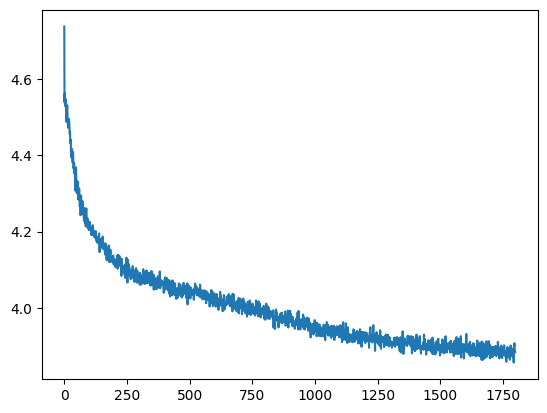

In [219]:
train_ae(train_data_loader, encoder, decoder, EPOCHS, LEARNING_RATE, device)

In [220]:
MNIST_test=torchvision.datasets.MNIST('./', download = True, train = False)

In [221]:
X_test = MNIST_test.train_data/255

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [222]:
X_test = X_test.unsqueeze(1).to(device)

In [223]:
Z = encoder.sample_latent(X_test)[0] #скрытое пространство

In [224]:
import umap
import seaborn as sns

In [225]:
result=pd.DataFrame(Z.detach().cpu().numpy())

In [226]:
result.head(5) #получили 10000 объектов в скрытом состоянии

,0,1,2,3,4,5,6,7,8,9,...,480,481,482,483,484,485,486,487,488,489
0,-1.149688,0.169372,1.196942,-0.816910,0.017036,0.137122,-0.315202,-2.630781,1.506754,1.044170,...,0.823229,1.951135,-0.404286,-0.260285,-1.189461,-1.118078,-0.646086,-0.819413,0.494007,-0.171994
1,-1.608615,-1.781474,1.765976,-0.400877,-1.773365,-0.154573,-0.970538,-1.180667,0.702866,0.919324,...,-0.877283,1.079504,0.809599,0.484105,0.614556,-0.931691,1.756119,0.628146,-0.032041,-2.483316
2,-0.585608,-0.324630,-1.793519,0.912426,-0.994413,0.375133,1.316480,-0.341412,1.151806,-0.317132,...,0.985140,0.227309,-0.869066,-0.664359,2.141632,-0.933853,-1.356586,-1.659603,0.224290,-0.378073
3,-1.022772,-0.306290,0.776433,-1.632615,-0.977521,0.861848,0.465793,0.481403,0.050769,0.174765,...,-0.101847,1.691810,1.104761,-0.255050,0.484357,0.550305,0.662539,0.952208,-1.325988,-0.267373
4,-1.246939,1.152929,1.218729,0.319827,0.844550,0.871851,-0.836484,-0.712053,0.789988,0.175453,...,-1.063605,-1.547541,-0.170641,-0.168905,-1.183744,-0.527629,-0.419365,-1.332423,1.366534,-1.826735


In [227]:
a=umap.UMAP(random_state=123).fit_transform(result)

In [228]:
d = {'col1': a[:,0], 'col2': a[:,1]}
a = pd.DataFrame(data=d)
a['label'] = MNIST_test.test_labels

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [229]:
print(a)

          col1      col2  label
0     7.803476  2.486883      7
1     4.771696  4.268631      2
2     8.051675  4.754309      1
3     5.115625  6.313100      0
4     8.435719  5.501074      4
...        ...       ...    ...
9995  6.728047  4.976077      2
9996  7.990332  4.939369      3
9997  6.583430  3.146863      4
9998  5.627781  4.457015      5
9999  4.614187  5.541531      6

[10000 rows x 3 columns]


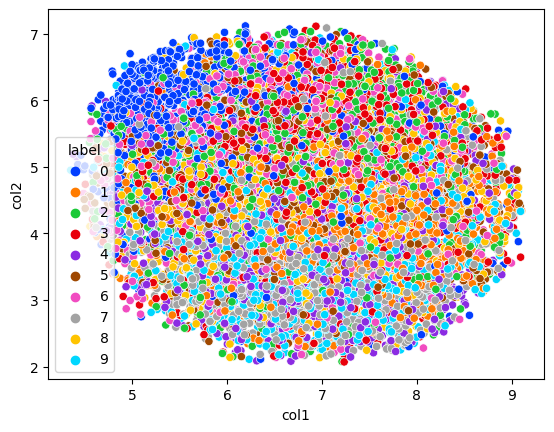

In [230]:
fig = plt.figure()
sns.scatterplot(x='col1',y='col2',data=a, palette='bright', hue=a['label'])
plt.show()

In [239]:
means = result.mean(axis=0)
vars = result.std(axis=0)**2

(array([  3.,   1.,   8.,  93., 372.,   8.,   2.,   1.,   1.,   1.]),
 array([-0.38878897, -0.29468459, -0.20058021, -0.10647582, -0.01237144,
         0.08173294,  0.17583732,  0.26994172,  0.3640461 ,  0.45815048,
         0.55225486]),
 <BarContainer object of 10 artists>)

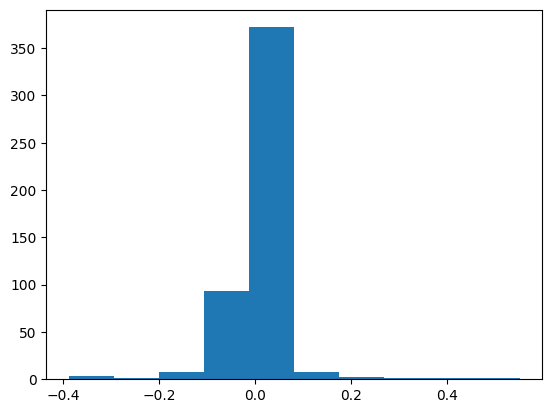

In [240]:
plt.hist(means)

(array([  4.,   9.,  13., 254., 202.,   3.,   3.,   0.,   0.,   2.]),
 array([0.78460246, 0.83889031, 0.89317816, 0.94746602, 1.00175393,
        1.05604172, 1.11032963, 1.16461742, 1.21890533, 1.27319312,
        1.32748103]),
 <BarContainer object of 10 artists>)

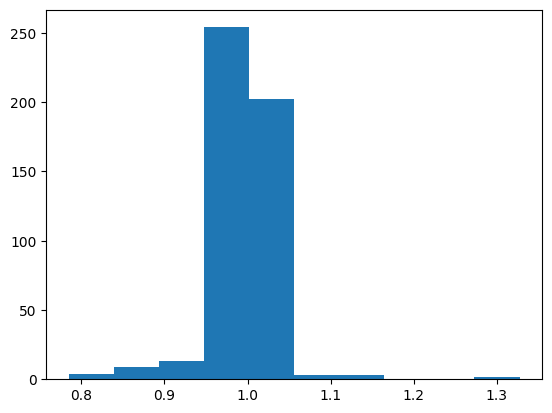

In [241]:
plt.hist(vars)

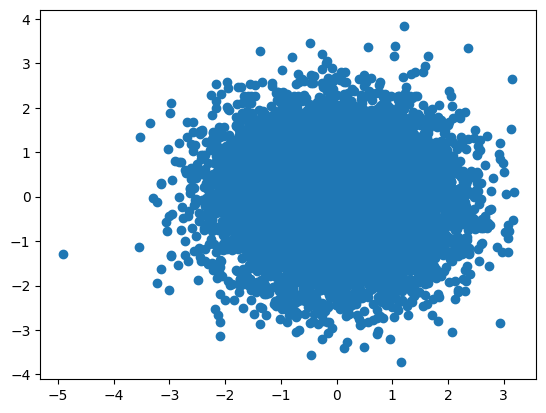

In [242]:
plt.scatter(result.iloc[:,0],result.iloc[:,1])

In [243]:
restored_imgs = decoder(Z[:5].reshape(5, 10, 7, 7))


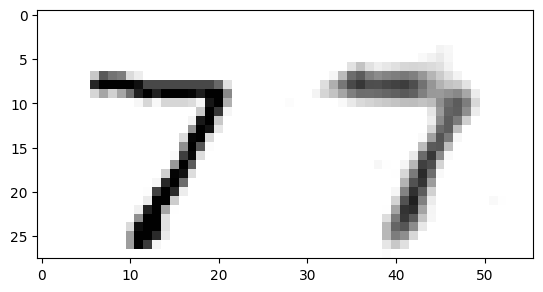

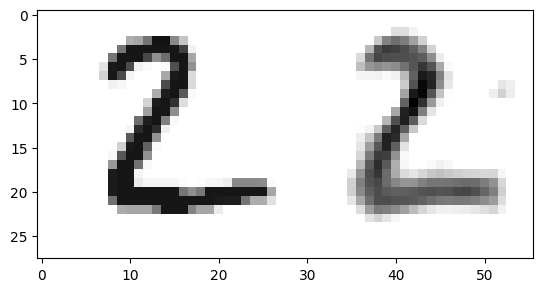

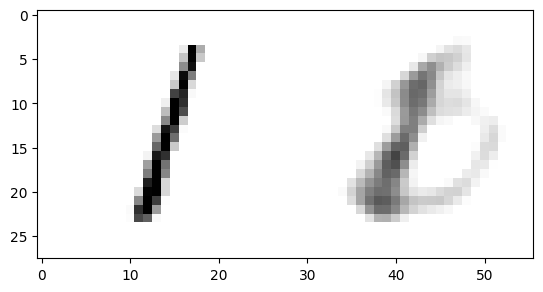

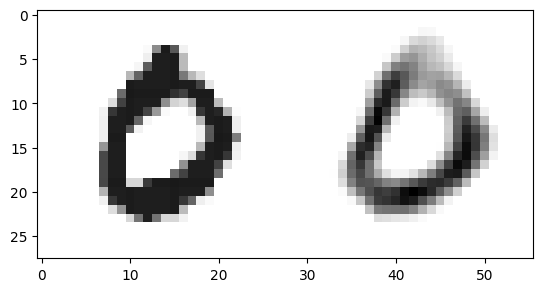

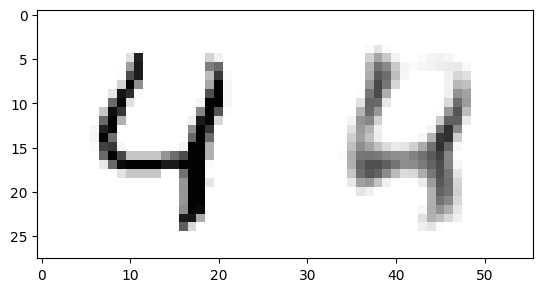

In [244]:
for i in range(restored_imgs.shape[0]):
  orig_restored = torch.hstack((X_test[i][0], restored_imgs[i][0].detach()))
  plt.imshow(orig_restored.cpu().numpy(), cmap='Greys')
  plt.show()

In [245]:
gen_latent.shape

torch.Size([123, 490])

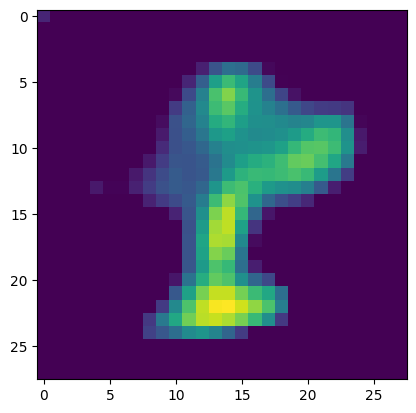

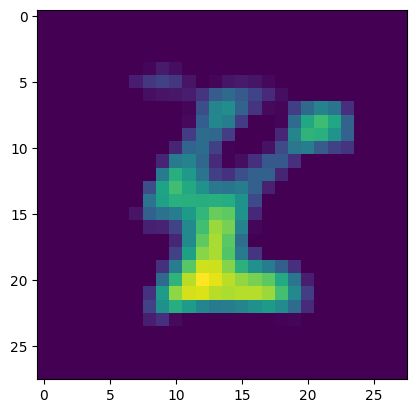

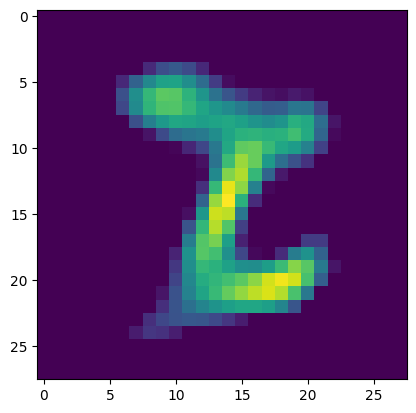

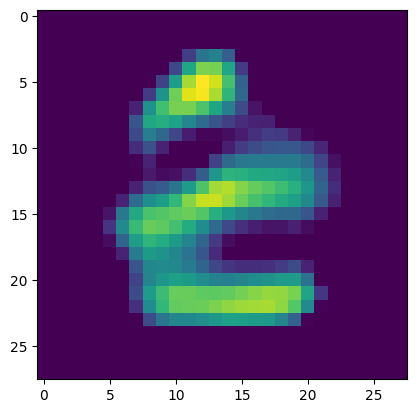

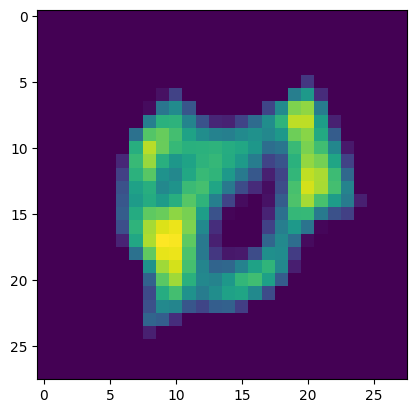

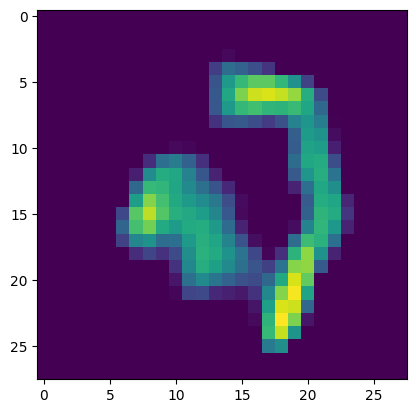

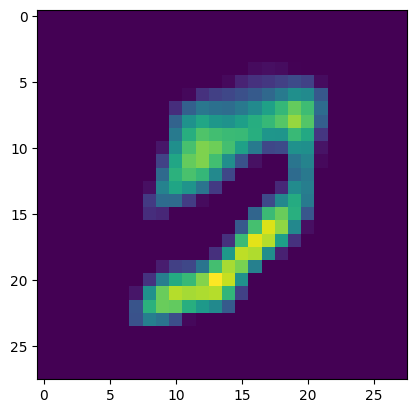

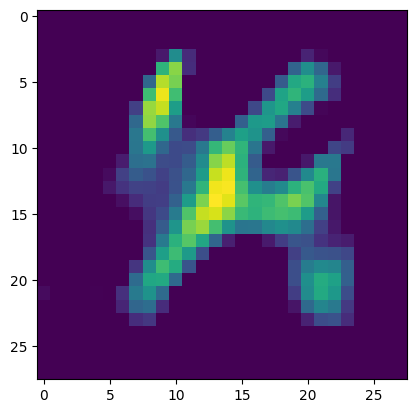

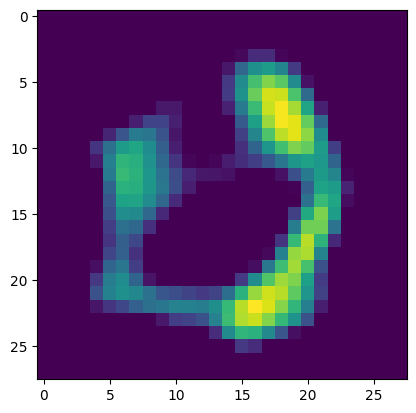

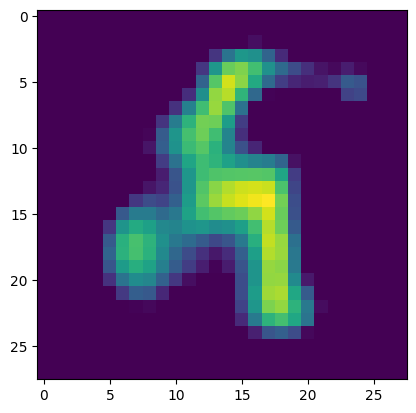

In [247]:
#генерация новых точек 

for _ in range(10):
    gen_latent = torch.randn(123, LATENT_SIZE, device=device)
    gen_digit = decoder(gen_latent.reshape(123, 10, 7, 7)).cpu()
    plt.imshow(gen_digit.detach()[0].reshape(28, 28).numpy())
    plt.show()